# Demo code: Generative Adversarial Networks (GANs)

This demo we will demo code for using GAN model to genrate the image:

-   Dataset: A-Side dataset of our product DCV81
    -   Train folder:
        -   A1 folder: Sample NG (17 images)
    -   Validation folder:
        -   A1 folder: Sample NG (6 images)
    -   Test folder:
        -   A1 folder: Sample NG (6 images) 
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)

Tasks Outlines:
## Task 0: Preparing dataset
-   0.1. Define a function get all paths to each image in the dataset and the class label of each image
-   0.2. Define a function to get all image array and its class label (which are in typy np.array)
-   0.3. Getting data by using two previous function
-   0.4. Normalize dataset and reshape dataset to standard form
## Task 1: Constructing GAN model by using TensorFlow library:
## Task 2: Evaluating the trained model on the testset
## Task 3: Loading the trained model and Exploring the detail of convolutional layers
-   3.1. Loading the trained model.
-   3.2. Exploring 
*****************************************************************************


## Import all packages

In [2]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.models import Model

from sklearn import metrics

## Task 0: Preparing Dataset

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [3]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Good":0,"A1":1}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root,file)

            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(file_path)
                folder_name = os.path.basename(os.path.dirname(file_path))
                list_labels.append(label_to_number[folder_name])
    return (list_img_paths,list_labels)

### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [4]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 32,
             height:int = 32) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img).convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [5]:
# Setting for image shape
width = 64 # <--- width of image:
height = 64 # <--- height of image:
n_channels = 1

In [6]:
# Get the list images path and list labels of train, val, test
data_dir = "/Users/user/Victor2023/Dataset/Data_CNN" # Replace this directory by the directory to data in your computer
train_dir = os.path.join(data_dir,"Train")
val_dir = os.path.join(data_dir,"Val")
test_dir = os.path.join(data_dir,"Test")

list_imgs_train,list_labels_train = get_all_img_label_path(input_dir=train_dir,
                                                    img_suffix='.bmp')
list_imgs_val,list_labels_val = get_all_img_label_path(input_dir=val_dir,
                                                    img_suffix='.bmp')
list_imgs_test,list_labels_test = get_all_img_label_path(input_dir=test_dir,
                                                    img_suffix='.bmp')

In [7]:
X_train,label_train = get_data(list_img_paths=list_imgs_train,
               list_labels=list_labels_train,
               is_resize=True,
               width=width,
               height= height)

X_val,label_val = get_data(list_img_paths=list_imgs_val,
               list_labels=list_labels_val,
               is_resize=True,
               width=width,
               height= height)

X_test,label_test = get_data(list_img_paths=list_imgs_test,
               list_labels=list_labels_test,
               is_resize=True,
               width=width,
               height= height)

### 0.4. Normalize dataset and reshape dataset to standard form

#### Warning !!

The shape of data image input for CNN model should be (N_samples,height, width, n_channels). In which:
-   N_samples: The total number of samples we have (number of images)
-   height: the height of image
-   width: the width of image
-   n_channels: number of channels in image (our case is gray scale image => n_channels = 1)

Back to our data:
-   Data is image in grayscale we resize to same size (height,width), here is 64 x 64 pixels. The number of channels in image is 1 
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height,width,n_channels)

In [8]:
n_samples_train = X_train.shape[0]
X_train = X_train.reshape((n_samples_train,height,width,n_channels))
# Scaling feature from range [0,255] to range [0,1]
X_train = X_train/255.0
# Convert integers to dummy variables (i.e. one hot encoded)
# Formating the truth label in form of output of model
# y now is the truth output which model must learn to predict
y_train = to_categorical(label_train)

In [9]:
n_samples_val = X_val.shape[0]
X_val = X_val.reshape((n_samples_val,height,width,n_channels))
X_val = X_val/255.0
y_val = to_categorical(label_val)

In [10]:
n_samples_test = X_test.shape[0]
X_test = X_test.reshape((n_samples_test,height,width,n_channels))
X_test = X_test/255.0
y_test = to_categorical(label_test)

In [11]:
print("The currently shape of input dataset X is:", X_train.shape)
print("The currently shape of dummy y is:", y_train.shape)

The currently shape of input dataset X is: (47, 64, 64, 1)
The currently shape of dummy y is: (47, 2)


In [12]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the train subset:", len(y_val))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 47
Number of samples in the train subset: 16
Number of samples in the test subset: 16


Show the images of the train set:


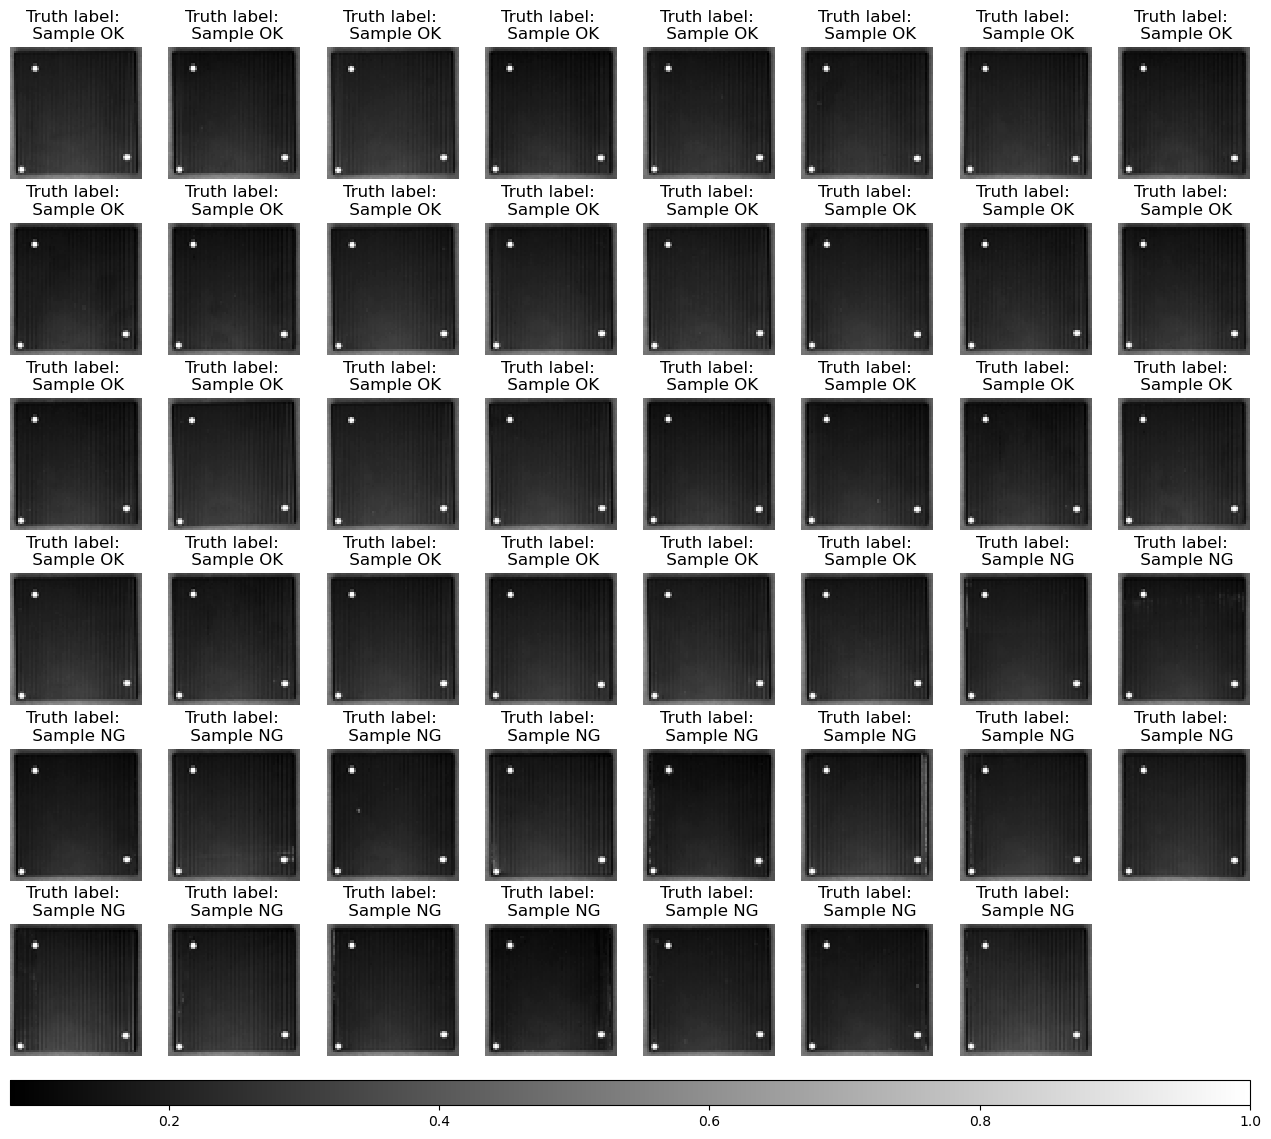

In [13]:
print("Show the images of the train set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 6,ncols = 8, figsize= (16,16))
for r in range(6):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_train[index].reshape((width,height))
        true_label = truth_train[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
        if index == 46:
            axes[5,7].set_axis_off()
            break
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Show the images of the validation set:


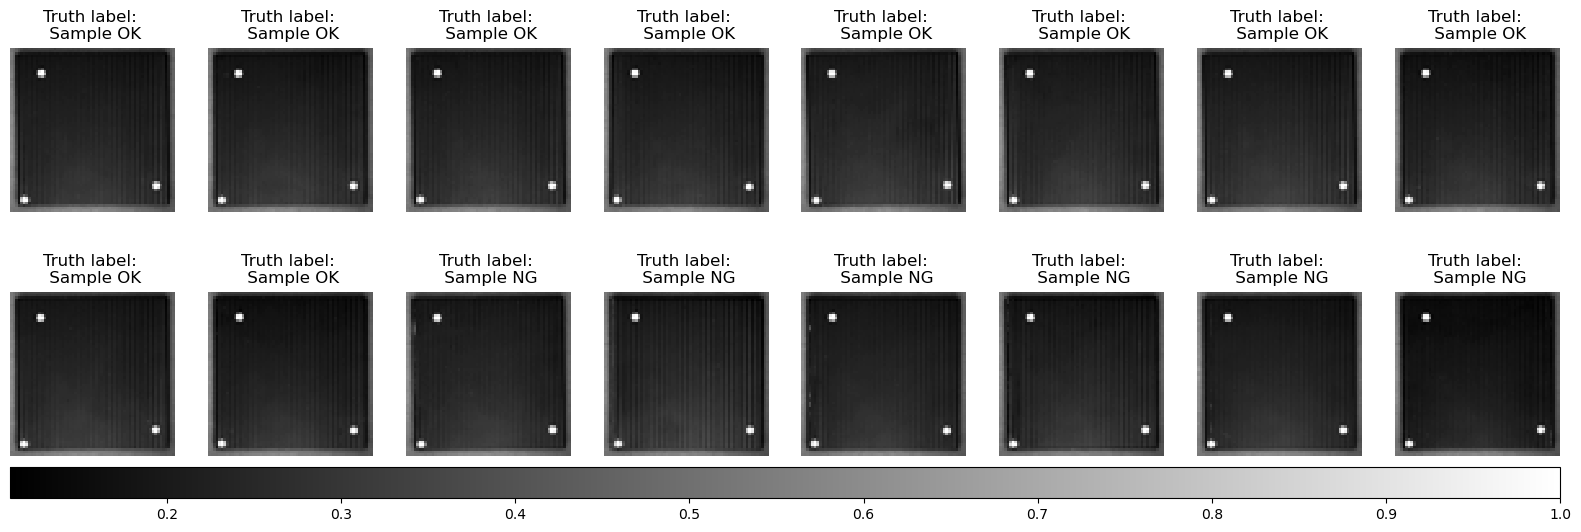

In [14]:
print("Show the images of the validation set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,7))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_val[index].reshape((width,height))
        true_label = label_val[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

Show the images of the test set:


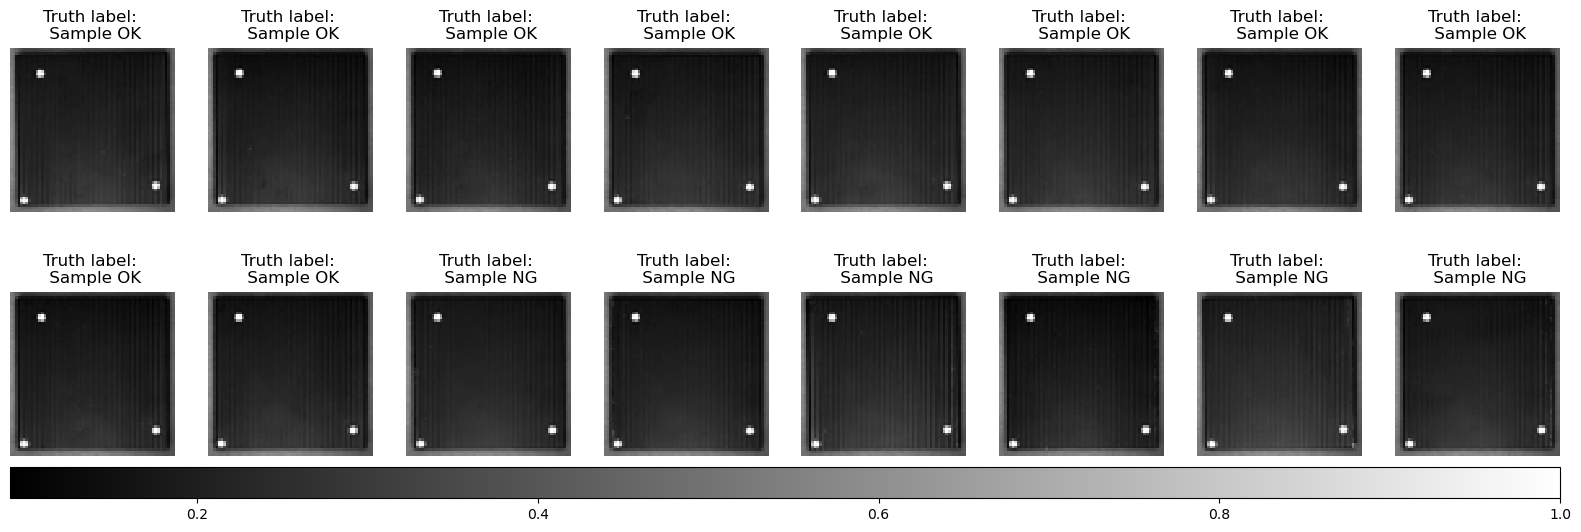

In [15]:
print("Show the images of the test set:")
class_to_label = {0: "Sample OK", 1: "Sample NG"}
truth_train = np.argmax(y_train,axis=-1)
fig,axes = plt.subplots(nrows = 2,ncols = 8, figsize= (20,7))
for r in range(2):
    for c in range(8):
        index = r*8 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        true_label = label_test[index]
        photo = axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        axes[r,c].set_title(f"Truth label: \n {class_to_label[true_label]}")
        # cbar = fig.colorbar(photo)
fig.colorbar(photo, ax=axes.ravel().tolist(), orientation='horizontal',aspect=50,pad=0.02)

## Task 1: Constructing GAN model by using TensorFlow library:

### 1.1. Constructing Generator Model

The Generator model (G model) takes random noise as an input and outputs an image that resembles the training images. Here, we configure the G model to generate a 64 x 64 gray-scale image.

-   The 1st layer is Dense (fully connected) layer
-   The 2nd layer is Upsampling layer (Conv2DTranspose)


In [16]:
# Dimension of the random noise
NOISE_DIM = 100
# Weight initializer for G model
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
# Number of channels
CHANNELS = 1

In [17]:
# Create G model
model = Sequential(name='generator')

2024-02-15 10:04:56.350980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Construct the Dense layer
model.add(layers.Dense(16*16*256, input_dim = NOISE_DIM))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
# Reshape
model.add(layers.Reshape((16,16,256)))

In [19]:
# Upsample to 32x32: Applying a transpose CONV => BatchNormalization => Actiation ReLU
model.add(layers.Conv2DTranspose(filters = 128,
                                 kernel_size=(5,5),
                                 strides=(2,2),
                                 padding='same',
                                 kernel_initializer=WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

In [20]:
# Upsample to 64x64: Applying a transpose CONV => BatchNormalization => Activation ReLu
model.add(layers.Conv2DTranspose(filters = 64,
                                 kernel_size = (5,5),
                                 strides = (2,2),
                                 padding = 'same',
                                 kernel_initializer = WEIGHT_INIT))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [21]:
# Finally, use a CONV2D layer with activation of tanh to make an image of shape 64x64x1.
model.add(layers.Conv2D(filters = CHANNELS,
                        kernel_size = (5,5),
                        padding = 'same',
                        activation = 'tanh'))

In [22]:
# Show the model summary
model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      51

### 1.1. Constructing Discriminator Model

The Discriminator model (D model) is a simple binary classifier that tells whether an image is real or fake.

-   The 1st layer is Dense (fully connected) layer
-   The 2nd layer is Upsampling layer (Conv2DTranspose)
